# Question 1: 
- Suppose you own a real estate agency. Your agency makes 3% commission on each sale, half goes to the agent handling the sale and half goes to the company. So, on a $250,000 sale your company makes $3,750.
- Using the housing data, how might you roughly segment the housing market? For example, is it advisable to ignore houses with fireplaces, or focus on older homes?
    1. Explore the data (plots and summaries), and try to come up with a regression model that will accurately predict the selling price (and in turn, your profit).
    2. What is your strategy for allocating your realtors?

- Dataset: Contains 1057 observations.


The schema for this dataset is as follow:
|Variable|Description|
|------------|-----------------------|
| Price      | Price of each property|
| Area | Area of property |
| Bedrooms    | Number of bedrooms in property |
| Bathrooms   | Number of bathrooms in property|
|Fireplaces|Number of fireplaces in property|
|Age|Age of property|




In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
from sklearn.metrics import r2_score

In [2]:
df = pd.read_excel('Housing.xlsx', index_col=0)

In [3]:
df.head()

,Price,Area,Bedrooms,Bathrooms,Fireplaces,Age
1,142212,1982,3,1.0,0,133
2,134865,1676,3,1.5,1,14
3,118007,1694,3,2.0,1,15
4,138297,1800,2,1.0,2,49
5,129470,2088,3,1.0,1,29


- At first glance, I immediately realize the commonality between this question with the famous Kaggle competition, which is ubiquitous in data science community. There are hundreds of best practices on this problem but I will try to tackle the issue in the most relevant way to get the most out of the given data.
- Before get into any data science project, the first step is to understand the problem throughoutly. Thus, I will divide the above questions into 3 executable tasks:
    + Interpretability: Analyzing the relationship between housing "Price" and the other features
    + Prediction: Build a regression model to predict housing "Price" (and Profit) based on selected features
    + Decision: from the predicted model, propose a strategy to aid realtor allocation decision
- As the most saying in science field indicates that "Garbage in, garbage out", the most important step in dealing with a data science problems is data cleansing. But as far as I can perceive, the data is rather clean and compact when it contains only 1 target variable (Price) and 5 features. So that, I will jump right into the feature selection and engineering phase which involve analyzing the relationship between independent and dependent variables. 

# I. Interpretability : Exploratory data analysis


## Detect data anomaly: missing data and outliers
- Before jumping into the main parts, I will handle some data issues (if exists) to prevent bias


In [4]:
#missing data
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Price,0,0.0
Area,0,0.0
Bedrooms,0,0.0
Bathrooms,0,0.0
Fireplaces,0,0.0
Age,0,0.0


The data is pretty neat when there is no missing data point
- Next, I will check outlier existence

In [5]:
# calculate interquartile range
q25, q75 = np.percentile(df.Price, 25), np.percentile(df.Price, 75)
iqr = q75 - q25
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
# calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
# identify outliers
outliers = [x for x in df.Price if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))
# remove outliers
outliers_removed = [x for x in df.Price if x >= lower and x <= upper]
print('Non-outlier observations: %d' % len(outliers_removed))
new_df=df[(df.Price >=lower)&(df.Price<=upper)]

Percentiles: 25th=112400.000, 75th=206512.000, IQR=94112.000
Identified outliers: 29
Non-outlier observations: 1028


- 29 outliers are removed and the data is ready to put in use

## Analysing dependant variable: Sale Price

In [6]:
new_df['Price'].describe()

count      1028.000000
mean     160353.680934
std       62422.708930
min       16858.000000
25%      111543.000000
50%      150434.000000
75%      201985.250000
max      345364.000000
Name: Price, dtype: float64

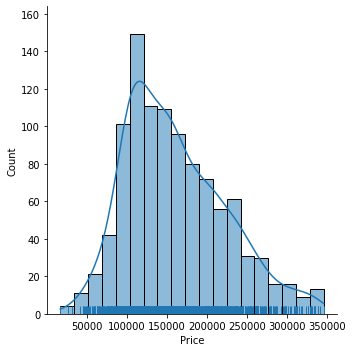

In [7]:
sns.displot(new_df.Price, kde =True, rug=True)

- From the descriptive statistics and the histogram, we can see that the distribution of the "Price" variable is non-normal and skews to the right, which is common in real-world practices

## Analyzing relationship between target and features

First, to get an overview over the correlation among variables, I construct a correlation matrix and then dig deeper into each feature with some plots.

- I plot the correlation matrix using the parametric Pearson method to illustrate the univariate linear relationship among variables

In [8]:
corr = new_df.corr(method='pearson')
corr.style.background_gradient(cmap='coolwarm')

,Price,Area,Bedrooms,Bathrooms,Fireplaces,Age
Price,1.000000,0.763353,0.480558,0.668545,0.447884,-0.379630
Area,0.763353,1.000000,0.662613,0.713283,0.473113,-0.263990
Bedrooms,0.480558,0.662613,1.000000,0.490634,0.265391,-0.064075
Bathrooms,0.668545,0.713283,0.490634,1.000000,0.422943,-0.450977
Fireplaces,0.447884,0.473113,0.265391,0.422943,1.000000,-0.224153
Age,-0.379630,-0.263990,-0.064075,-0.450977,-0.224153,1.000000


In [9]:
def line_of_best_fit(X, y):
    theta = np.polyfit(X,y,1)
    y_line=theta[1] + theta[0]*X
    plt.scatter(x=X, y=y)
    plt.plot(X, y_line, 'r')

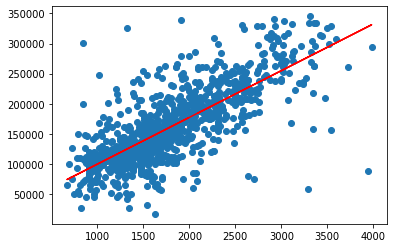

In [10]:
line_of_best_fit(new_df.Area, new_df.Price)

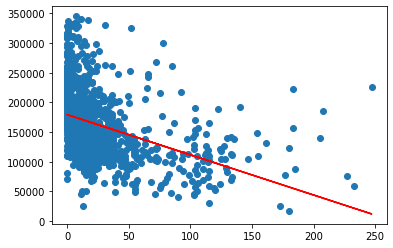

In [11]:
line_of_best_fit(new_df.Age, new_df.Price)

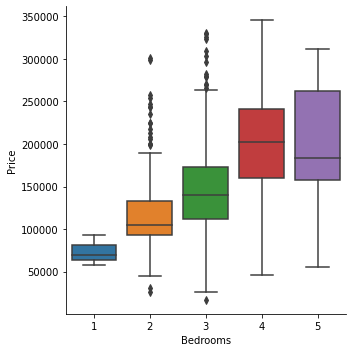

In [12]:
sns.catplot(x='Bedrooms', y='Price', data=new_df, kind='box')

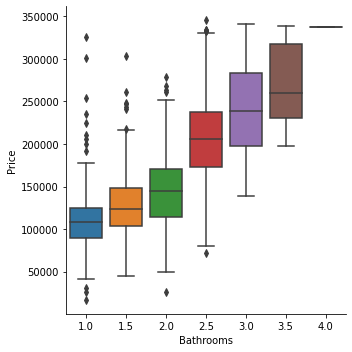

In [13]:
sns.catplot(x='Bathrooms', y='Price', data=new_df, kind='box')

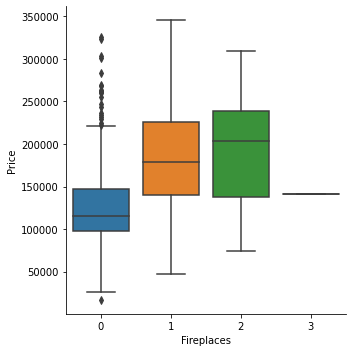

In [14]:
sns.catplot(x='Fireplaces', y='Price', data=new_df, kind='box')

+ It seems that house with bigger "Area" and higher number of "Bathrooms" significantly has higher prices. We can see that "Area" is highly correlated with "Bathrooms" and "Bedrooms", which possibly poses multicollinearity problem. This can bias the interpretabilty, so that I compute the Variance Inflation Factor (VIF) score:

In [15]:
def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

In [16]:
df_vif = new_df.iloc[:,1:]
calc_vif(df_vif)

,variables,VIF
0,Area,27.642677
1,Bedrooms,25.306821
2,Bathrooms,21.647955
3,Fireplaces,3.055446
4,Age,1.880810


- We can see that "Area", "Bedrooms" and "Bathrooms" have pretty high VIF, which indicates that they can be predicted by other independent variable in the data. It is reasonable that "Area" can be well explained by "Bedrooms" and "Bathrooms" and I will try to drop these room-related features 

In [17]:
df_vif = new_df.drop(columns =['Price', 'Bathrooms', 'Bedrooms'])
calc_vif(df_vif)


,variables,VIF
0,Area,3.634264
1,Fireplaces,3.010417
2,Age,1.413096


- And voilà, the VIF score drop significantly 

- In the famous book "An introduction to statistical learning", there is a recommendation that when it comes to interpreting the effect of independent features on dependent variable, a simple linear regression fits the job best. Thus, in order to get a sense of how independent variables affect the target, I simply regress those features on the target using multivariate linear regression model.

In [18]:
model = smf.ols(formula='Price ~ Area + Fireplaces + Age', data = new_df)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     563.6
Date:                Sun, 23 Jan 2022   Prob (F-statistic):          3.23e-216
Time:                        14:30:13   Log-Likelihood:                -12308.
No. Observations:                1028   AIC:                         2.462e+04
Df Residuals:                    1024   BIC:                         2.464e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    4.11e+04   4167.846      9.861      0.0

- From the summary above, it is evident that all 3 variables significantly drive the "Price" figure with p-value < 0.05. While the Area has a moderate effect with low deviation (when increasing one unit, Price will increase ~70), the Fireplaces is wildly off the mark when it has a very high deviation. With regards to the Age varibale, although this is time-related variable, there might be some other factors coming into the way like inflation or gorvernment policy that can significantly drive the Price, this variable is still an effective predictor.
- In conclusion, all three factors: Area, Age, and Fireplaces have an impact on the Price and should be taken into consideration when predicting the Price.

# House clusters

As the case studty question require, I will segment those houses in the dataset into clusters by using K-Means Clustering technique. I will based on the RFM models using Area, Age, Fireplaces, and Price figures and calculate a final score to segment houses

Text(0, 0.5, 'WCSS')

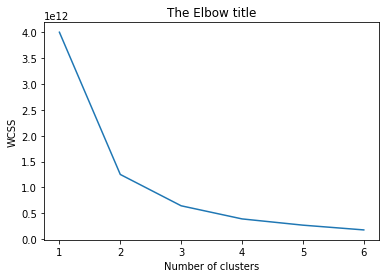

In [33]:
# First, I will find the most appropriate number of clusters based on the price
wcss=[]
for i in range(1,7):
    kmeans = KMeans(i)
    kmeans.fit(new_df[['Price']])
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)

number_clusters = range(1,7)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

It seems that 3 is a good number of clusters

In [37]:
# Define a function to sort the cluster in a proper order
def sort_cluster(cluster, value, data, ascending):
    cluster_sort = data.groupby(cluster)[value].mean().reset_index()
    cluster_sort = cluster_sort.sort_values(by=value, ascending=ascending).reset_index(drop=True)
    cluster_sort['index'] = cluster_sort.index
    df_cluster = data.merge(cluster_sort[['index', cluster]], on=cluster)
    df_cluster.drop(columns=cluster, inplace=True)
    df_cluster.rename(columns ={'index':cluster}, inplace=True)
    return df_cluster

In [41]:
df_cluster = new_df.copy()

In [47]:
# Calculate Area Score
# The number of cluster chosen is 3
kmean = KMeans(n_clusters=3)
kmean.fit(new_df[['Area']])
df_cluster['AreaCluster']=kmean.predict(new_df[['Area']])
df_cluster = sort_cluster('AreaCluster', 'Area', df_cluster, True)
df_cluster.groupby('AreaCluster').agg({'Area':['mean','count']})

Area      
                    mean count
AreaCluster                   
0            1770.525469   373
1            1788.531429   175
2            1789.056250   480

In [50]:
# Calculate Age Score
# The number of cluster chosen is 3
kmean = KMeans(n_clusters=3)
kmean.fit(new_df[['Age']])
df_cluster['AgeCluster']=kmean.predict(new_df[['Age']])
df_cluster = sort_cluster('AgeCluster', 'Age', df_cluster, False)
df_cluster.groupby('AgeCluster').agg({'Age':['mean','count']})

Age      
                 mean count
AgeCluster                 
0           33.695122    82
1           30.309013   233
2           26.862553   713

In [52]:
# Calculate Fireplaces Score
# The number of cluster chosen is 3
kmean = KMeans(n_clusters=3)
kmean.fit(new_df[['Fireplaces']])
df_cluster['FireplacesCluster']=kmean.predict(new_df[['Fireplaces']])
df_cluster = sort_cluster('FireplacesCluster', 'Fireplaces', df_cluster, True)
df_cluster.groupby('FireplacesCluster').agg({'Fireplaces':['mean','count']})

Fireplaces      
                        mean count
FireplacesCluster                 
0                   0.555294   425
1                   0.644330   582
2                   0.666667    21

In [53]:
# Calculate Price Score
# The number of cluster chosen is 3
kmean = KMeans(n_clusters=3)
kmean.fit(new_df[['Price']])
df_cluster['PriceCluster']=kmean.predict(new_df[['Price']])
df_cluster = sort_cluster('PriceCluster', 'Price', df_cluster, True)
df_cluster.groupby('PriceCluster').agg({'Price':['mean','count']})

Price      
                       mean count
PriceCluster                     
0             155956.989848   197
1             156806.166297   451
2             166843.357895   380

In [58]:
# overall scoring
df_cluster['OverallScore'] = df_cluster.AreaCluster + df_cluster.AgeCluster + df_cluster.PriceCluster +df_cluster.FireplacesCluster
df_cluster['Segment'] = 'Low-Value'
df_cluster.loc[df_cluster['OverallScore']>2,'Segment'] = 'Mid-Value' 
df_cluster.loc[df_cluster['OverallScore']>4,'Segment'] = 'High-Value' 
df_cluster.groupby('Segment').Segment.count()


Segment
High-Value    532
Low-Value      96
Mid-Value     400
Name: Segment, dtype: int64

In [65]:
df_cluster[['Price', 'Area', 'Fireplaces', 'Age', 'Segment']].groupby('Segment').mean().sort_values('Price')

,Price,Area,Fireplaces,Age
Segment,,,,
Low-Value,147767.979167,1747.489583,0.604167,30.020833
Mid-Value,158698.582500,1768.030000,0.600000,28.507500
High-Value,163869.219925,1799.201128,0.614662,27.618421


# Predicting Housing Price: XGBoost Model

As it comes to predicting stuff and the goal is accuracy, a complex tree-based model will do the job better than a naive linear regression.

First thing first, I divide the data sample into train and test group

In [19]:
df_train = new_df.copy()

from sklearn.model_selection import train_test_split
X = df_train.drop(columns = 'Price')
y = df_train['Price']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

Then I will apply Bayes statistics to find the best hyperparameter sets. The idea of this method is to assign each hyperparameter a distribution and then scan through every combinations of these to get the most optimized hyperparameters

In [20]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.choice('n_estimators', range(1000,10000)),
        'seed': 0
      }

def hyperparameter_tuning(space):
    model = xgb.XGBRegressor(n_estimators = space['n_estimators'],
                             max_depth = int(space['max_depth']),
                             gamma = space['gamma'],
                             min_child_weight = space['min_child_weight'],
                             reg_lambda = space['reg_lambda'],
                             reg_alpha = space['reg_alpha'],
                             colsample_bytree = space['colsample_bytree'],
                             eval_metric = 'rmse',
                             seed = 0
                             )
    
    evaluation = [( X_train, y_train), ( X_valid, y_valid)]
    
    model.fit(X_train, y_train,
             eval_set=evaluation, 
             eval_metric="rmse",
             early_stopping_rounds=10,
             verbose = False
             )

  
    pred = model.predict(X_valid)
    score = mean_squared_error(y_valid, pred, squared=False)
    
    print ("SCORE:", score)
    return {'loss':score, 'status': STATUS_OK, 'model': model}
 

trials = Trials()
best = fmin(fn = hyperparameter_tuning,
            space = space,
            algo = tpe.suggest,
            max_evals = 100,
            trials = trials,
            rstate = np.random.RandomState(0)
            )

print(best)

SCORE:
46918.4001114622
SCORE:
43416.75397892301
SCORE:
45112.058227369984
SCORE:
44598.20896391711
SCORE:
44311.651571376344
SCORE:
44312.497832867164
SCORE:
43750.170226829956
SCORE:
43823.69366648302
SCORE:
44128.5713281731
SCORE:
43818.19014209633
SCORE:
43606.395599344854
SCORE:
44172.91735844871
SCORE:
44247.61155666703
SCORE:
44999.64998882301
SCORE:
42484.354523324924
SCORE:
46289.14371108489
SCORE:
41495.98691914532
SCORE:
43182.641468961105
SCORE:
44379.61087439944
SCORE:
44611.32682641643
SCORE:
45511.64208065667
SCORE:
44656.70974107701
SCORE:
42785.2749286285
SCORE:
45197.8638863381
SCORE:
43837.042393767304
SCORE:
43925.103037906374
SCORE:
43421.36792750377
SCORE:
43184.729806727344
SCORE:
44335.966330540105
SCORE:
43858.385726640394
SCORE:
42988.273260214424
SCORE:
43479.66046633973
SCORE:
44792.36474625217
SCORE:
43800.476637686486
SCORE:
43795.60315122743
SCORE:
43701.194396028244
SCORE:
43977.75542015913
SCORE:
43855.93528913486
SCORE:
43153.71233964959
SCORE:
44803.1

After I have figured out the best set of hyperparameters, I apply them to the model and do the prediction

In [30]:
best['max_depth'] = int(best['max_depth'])
my_model = xgb.XGBRegressor(**best)
evaluation = [( X_train, y_train), ( X_valid, y_valid)]

my_model.fit(X_train, y_train,
             eval_set=evaluation, 
             eval_metric="rmse",
             early_stopping_rounds=10,
             verbose = False
             )

# Preprocessing of validation data, get predictions
preds = my_model.predict(X_valid)

# Evaluate the model

print("RMSLE: ", mean_squared_log_error(y_valid, preds))
print(r2_score(y_valid, preds))

RMSLE:  0.0811878412614858
0.6056395322034995


- The model did a good job when its Root Mean Squared Logarithmic Error (RMSLE) has value below 0.1.
There are other algorithms like some complex ensemble models that might be more robust than the XGBoost itself, but as time is limited, I will stop here. And, as I stated before, focusing on preparing a more powerful dataset will boost the performance much more than a complex model.
- As the profit percentage is a static figure we can easily multiply the 1.5% (50% of 3%) to the predicted price to get the estimated profit.

# Strategy: Allocating realtors

- This question requires a real estate domain knowledge as there are many factors that can affect the allocating decision. However, under the scope of this case study and and the above analysis, I propose that the most appropriate allocating strategy is to assign the most valued house to the best realtors the agency has at hand provided that we already have an accurate predicted value of the house price. This can enhance the successful rate of selling house and optimize the profit the agency receives. If there is more dataset avaiable on not only the house properties but also the realtor characteristics and past performances, the insights will be more informative and clear.